In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

# Because the dataset is pretty big, you can specify low_memory = False to make sure that you get the variable types correct on your rows
# The dataset has a additional column at the top that you can skip using the skiprows argument
raw_data = pd.read_csv("LendingClub1pctSample.csv", low_memory = False, skiprows=[0])

# Let's eliminate the rows that aren't "complete"
# There's a decision to make here... technically, any defaulted loan could pay off.
# So we will drop the current loans and the ones that are a few months late and leave behind the defaults and the paid off loans
no_incomplete_rows = raw_data[raw_data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
no_incomplete_rows['loan_status'] = no_incomplete_rows['loan_status'].apply(lambda x: 0 if x == "Fully Paid" else 1)
print(no_incomplete_rows.shape)

# notice we only lose about 16,000 loans.  why might this be?
# maximum term length for loans on lending club is 60 months


(171483, 115)


In [2]:
# now it's time to clear up the leakage and other stuff
leakage_to_drop = ['issue_d', 'recoveries', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'last_credit_pull_d', 'total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d', 'total_rec_late_fee', 'total_rec_int', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'out_prncp', 'out_prncp_inv', 'pymnt_plan', 'next_pymnt_d']
no_information_features_to_drop = ['all_util', 'dti_joint', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m', 'open_rv_24m', 'total_bal_il', 'verification_status_joint', 'annual_inc_joint', 'application_type',  'policy_code', 'total_cu_tl']
text_columns = ['emp_title', 'url', 'desc', 'purpose', 'title', 'zip_code', 'id']


no_leakage = no_incomplete_rows.drop(text_columns + leakage_to_drop + no_information_features_to_drop, axis = 1)

# and it looks like there's a pesky % symbol in my interest rate variable
no_leakage['int_rate'] = pd.to_numeric(no_leakage['int_rate'].str.strip('%'), errors='coerce')
no_leakage['revol_util'] = pd.to_numeric(no_leakage['revol_util'].str.strip('%'), errors='coerce')

no_leakage['term'] = no_leakage['term'].apply(lambda x: x.strip().replace(" ", "_"))

no_leakage = no_leakage.drop(['earliest_cr_line'], axis = 1)

In [3]:
from sklearn import preprocessing

categorical = no_leakage.select_dtypes(include=['object'])
numeric = no_leakage.select_dtypes(exclude=['object'])

print(categorical.columns.values)

['term' 'grade' 'sub_grade' 'emp_length' 'home_ownership'
 'verification_status' 'addr_state' 'initial_list_status']


In [4]:
# create dummy variables
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)

term
grade
sub_grade
emp_length
home_ownership
verification_status
addr_state
initial_list_status


In [6]:
# imputation
for name in numeric:
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
        
y = numeric['loan_status']
X = numeric.drop(['loan_status'], axis = 1)

In [ ]:
# create a holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# choose the model
from sklearn import linear_model
lr = linear_model.SGDClassifier(loss='log', penalty='elasticnet', n_jobs = -1)

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', lr) ])

# tune the model
my_ratio = np.linspace(0.1,1, num = 10)
my_alpha = np.logspace(0.001, 1, num = 10)

from sklearn.model_selection import GridSearchCV
optimized_lr = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__alpha = my_alpha, model__l1_ratio = my_ratio)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_lr.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.8min


In [ ]:
print(optimized_lr.best_estimator_)
# print(optimized_lr.cv_results_)

# evaluate on holdout
from sklearn.metrics import roc_auc_score
y_pred = optimized_lr.predict_proba(X_test)[:, 1]

roc_on_holdout = roc_auc_score(y_test, y_pred)
print(roc_on_holdout)

# train model on entire dataset

final = pipeline.fit(X, y)


In [12]:
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# choose the model
my_tree = tree.DecisionTreeClassifier(criterion='entropy'
#                                       , splitter='best'
#                                       , max_features=None
#                                       , max_depth=3
#                                       , min_samples_split=100
#                                       , min_samples_leaf=50
#                                       , min_weight_fraction_leaf=0.0
#                                       , random_state=None
#                                       , max_leaf_nodes=None
#                                       , min_impurity_split=1e-07
#                                       , class_weight=None
#                                       , presort=False
                                     )

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', my_tree) ])

# tune the model
depth = np.linspace(1,10, num = 10)
print(depth)
# my_alpha = np.logspace(0.001, 1, num = 10)

from sklearn.model_selection import GridSearchCV
optimized_lr = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__max_depth = depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_lr.fit(X_train, y_train)





[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__max_depth': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [13]:
print(optimized_lr.best_estimator_)
# print(optimized_lr.cv_results_)

# evaluate on holdout
from sklearn.metrics import roc_auc_score
y_pred = optimized_lr.predict_proba(X_test)[:, 1]

roc_on_holdout = roc_auc_score(y_test, y_pred)
print(roc_on_holdout)

# train model on entire dataset

final = pipeline.fit(X, y)


Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5.0,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
0.692521342308


In [18]:
from sklearn import ensemble
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# choose the model
my_tree = ensemble.RandomForestClassifier(criterion='gini'
#                                           , max_depth=None
#                                           , min_samples_split=2
#                                           , min_samples_leaf=1
#                                           , max_features='auto'
#                                           , max_leaf_nodes=None
#                                           , bootstrap=True
#                                           , oob_score=False
#                                           , n_jobs=-1
#                                           , random_state=None
#                                           , verbose=0
#                                           , warm_start=False
#                                           , class_weight=None
#                                           , min_weight_fraction_leaf=0.0
#                                           , min_impurity_split=1e-07
                                         )

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', my_tree) ])

# tune the model
estimators = [10, 20, 30, 40, 50]
max_features = [5, 10, 15, 20, 25]
max_depth = [3, 4, 5, 6]

print(estimators)
# my_alpha = np.logspace(0.001, 1, num = 10)

from sklearn.model_selection import GridSearchCV
optimized_lr = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__n_estimators = estimators, model__max_features = max_features, model__max_depth=max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_lr.fit(X_train, y_train)



[10, 20, 30, 40, 50]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 34.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__max_depth': [3, 4, 5, 6], 'model__n_estimators': [10, 20, 30, 40, 50], 'model__max_features': [5, 10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [19]:
print(optimized_lr.best_estimator_)
# print(optimized_lr.cv_results_)

# evaluate on holdout
from sklearn.metrics import roc_auc_score
y_pred = optimized_lr.predict_proba(X_test)[:, 1]

roc_on_holdout = roc_auc_score(y_test, y_pred)
print(roc_on_holdout)

# train model on entire dataset

final = pipeline.fit(X, y)


Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=25, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
0.700425005752


In [22]:
# create a holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# choose the model
from sklearn import tree
my_tree = tree.DecisionTreeClassifier()

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', my_tree) ])

# tune the model
depth_values = [2, 3, 4, 5, 6, 7]

from sklearn.model_selection import GridSearchCV
optimized_lr = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(model__max_depth = depth_values)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_lr.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [20]:
np.linspace(0.1,1, num = 10)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [ ]:
# create a holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# choose the model
from sklearn import ensemble
forest = ensemble.RandomForestClassifier(random_state=1243)

# set up cv
from sklearn import model_selection
cv = model_selection.KFold(5)

# pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('my_model', forest) ])

# tune the model
number_of_trees = [10, 20, 30]
tree_depth = [3, 4, 5, 6, 7]
number_of_features = [10, 20, 30]

from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid=dict(my_model__n_estimators = number_of_trees
                                             , my_model__max_depth = tree_depth
                                             , my_model__max_features = number_of_features
                                             )
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)


Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min


In [ ]:
optimized_rf.best_estimator

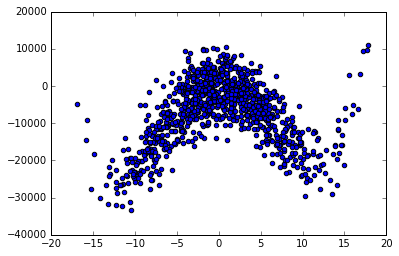

0


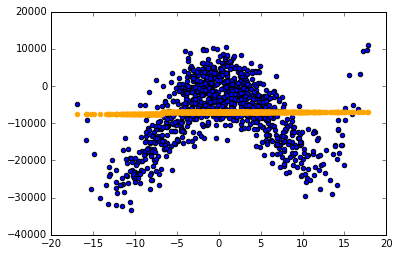

1


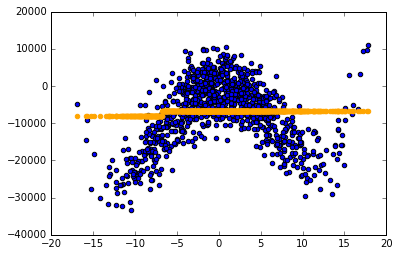

2


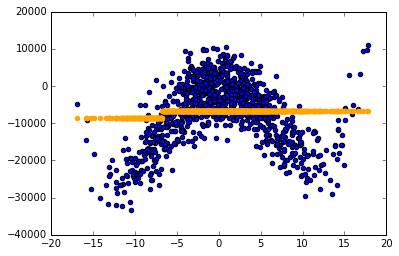

3


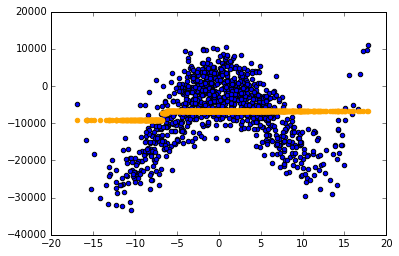

4


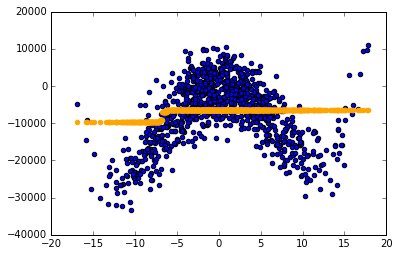

5


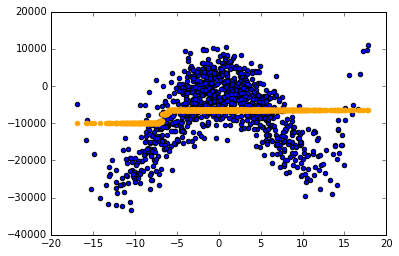

6


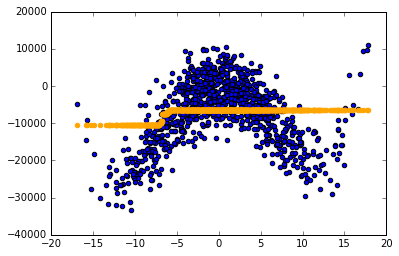

7


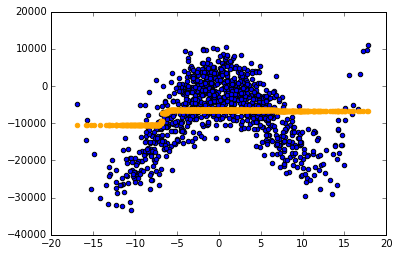

8


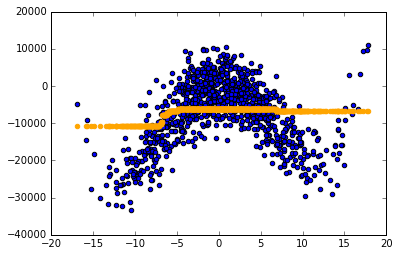

9


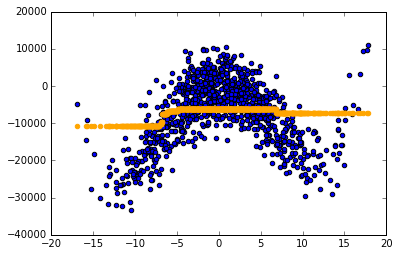

10


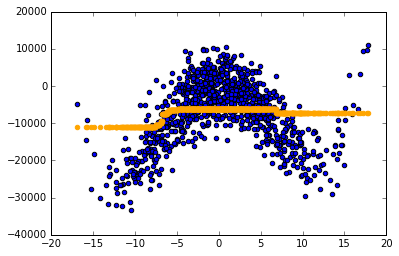

11


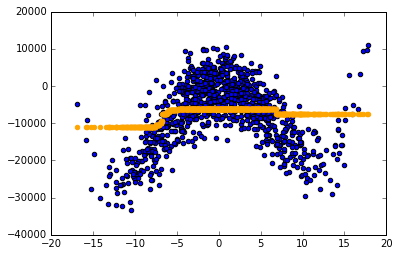

12


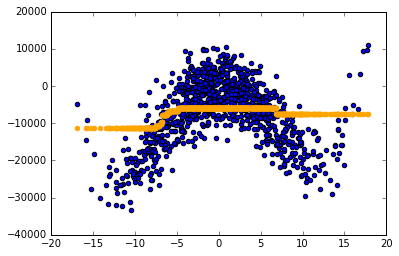

13


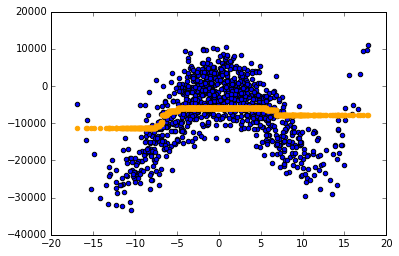

14


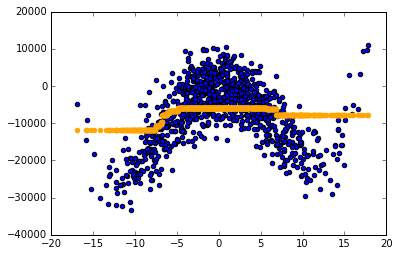

15


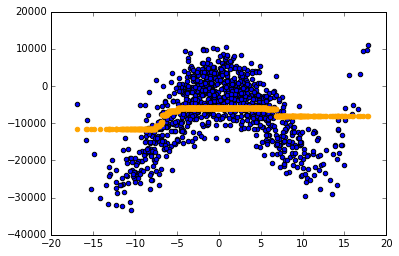

16


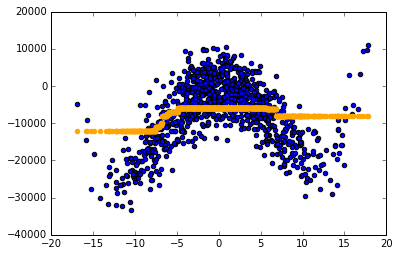

17


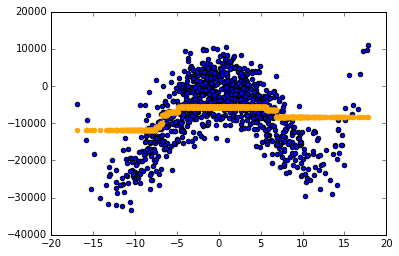

18


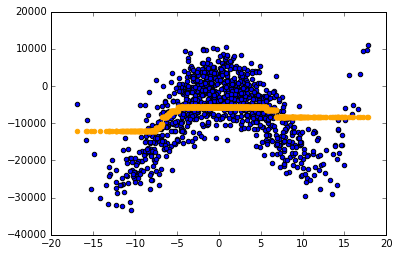

19


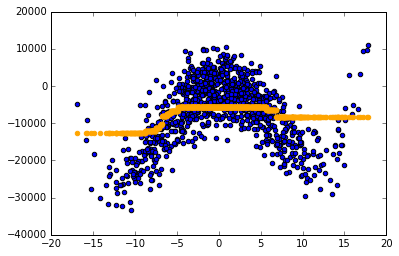

20


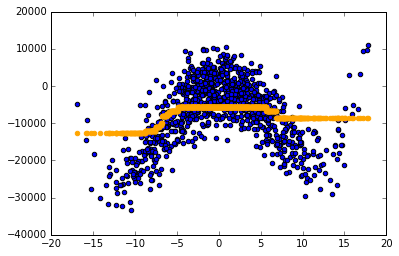

21


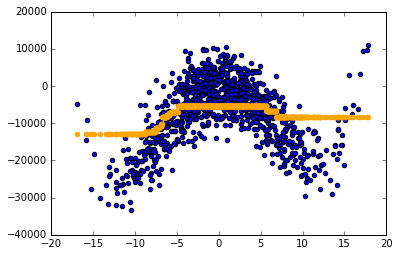

22


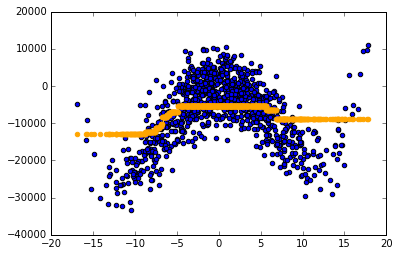

23


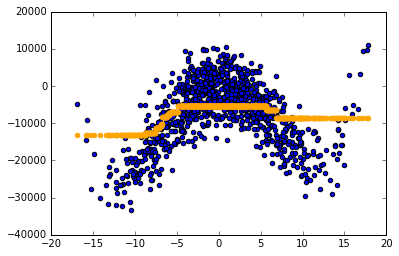

24


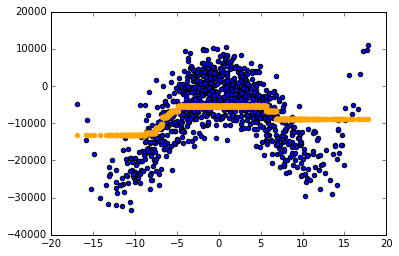

25


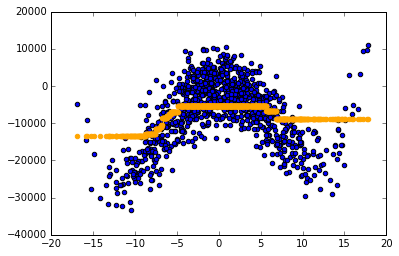

26


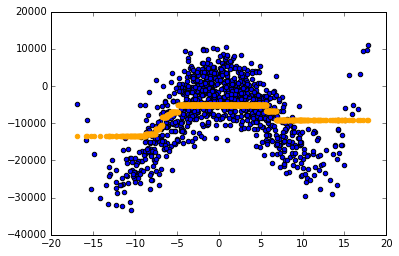

27


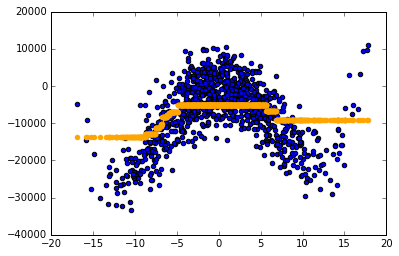

28


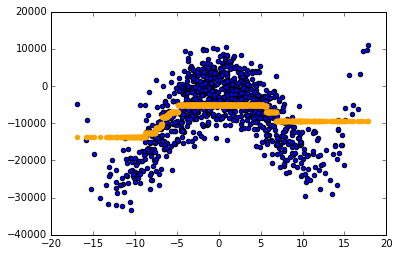

29


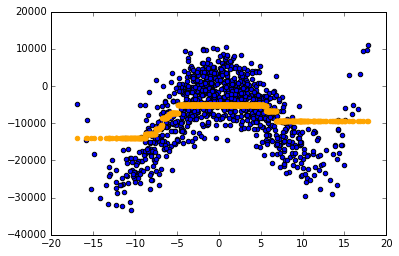

30


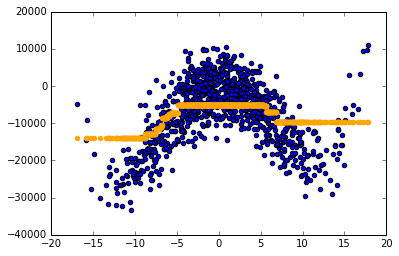

31


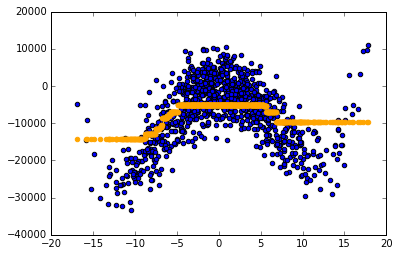

32


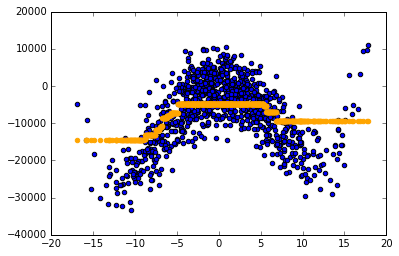

33


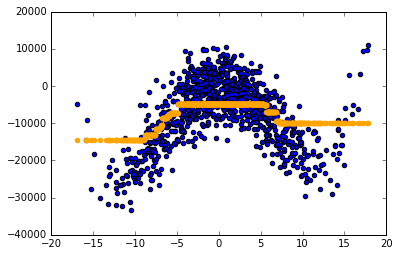

34


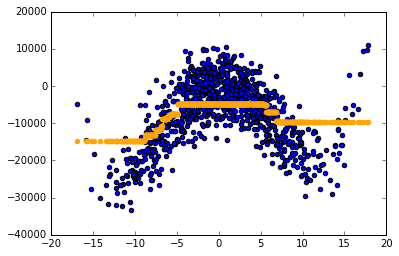

35


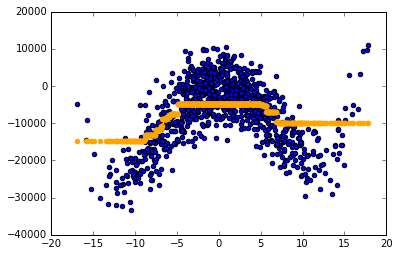

36


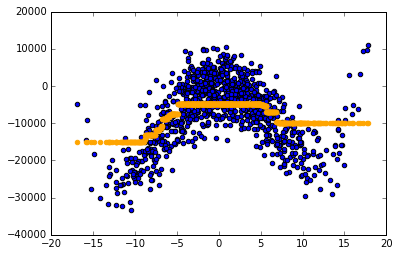

37


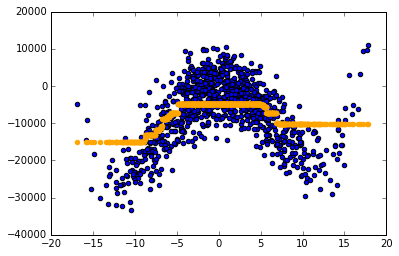

38


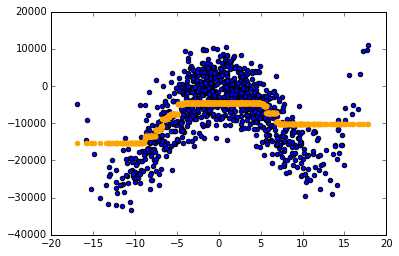

39


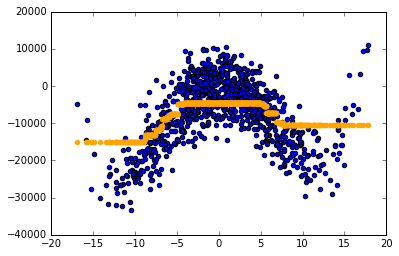

40


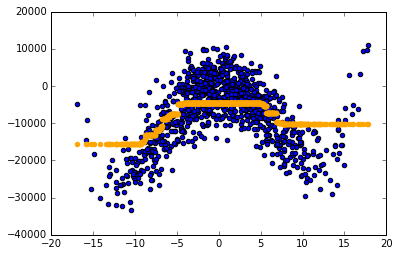

41


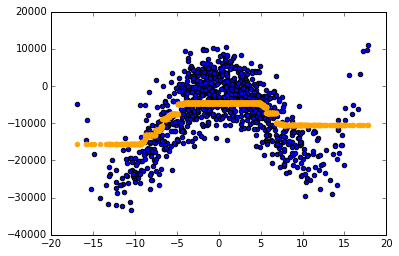

42


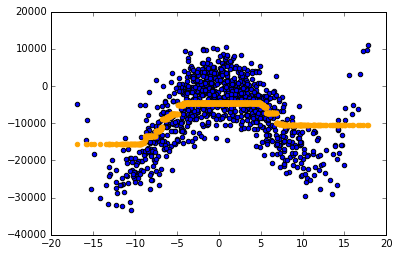

43


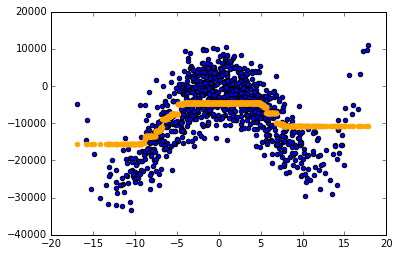

44


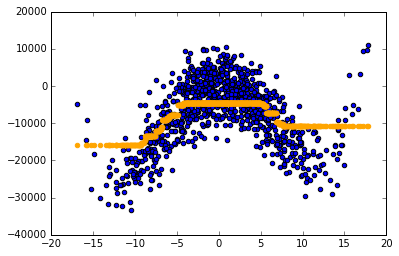

45


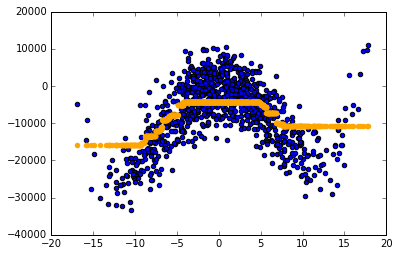

46


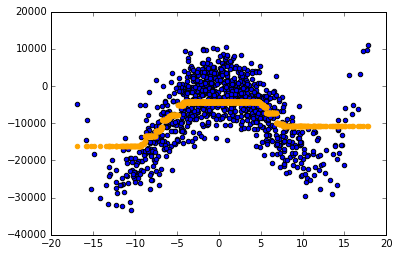

47


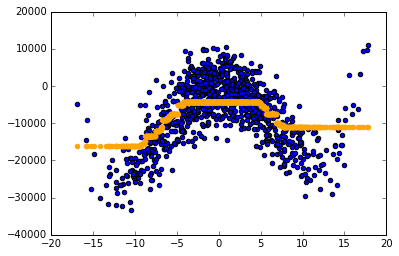

48


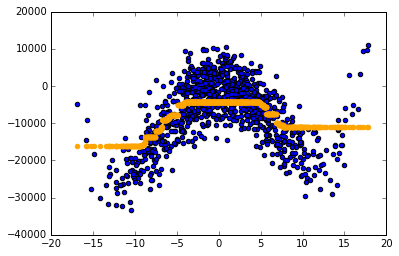

49


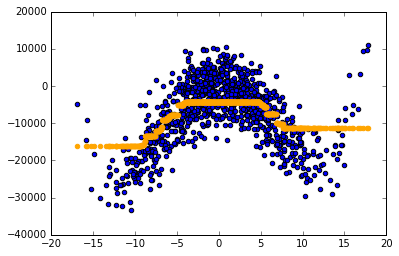

50


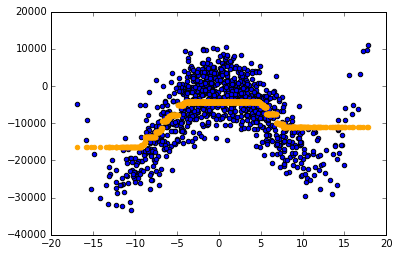

51


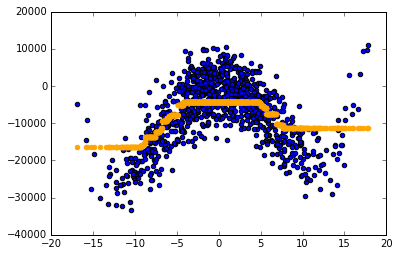

52


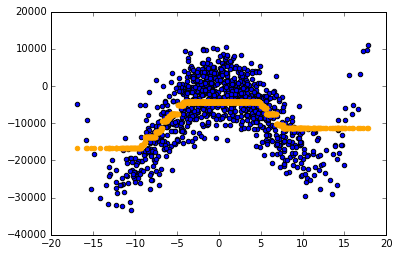

53


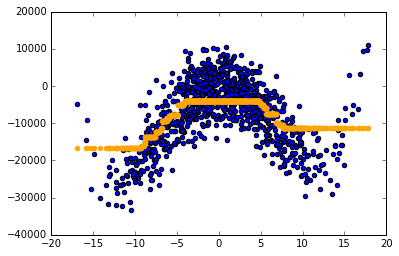

54


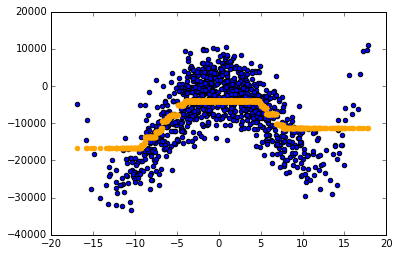

55


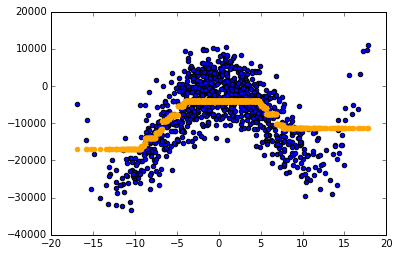

56


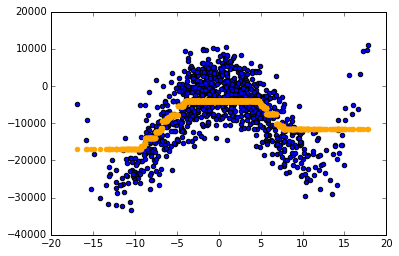

57


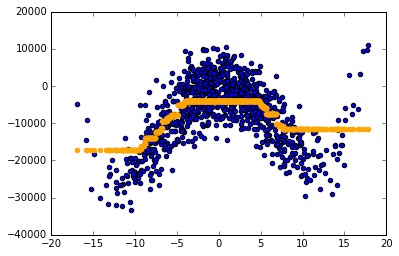

58


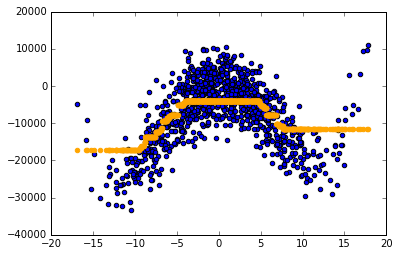

59


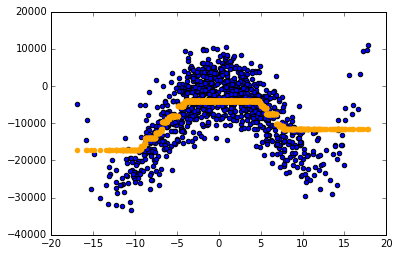

60


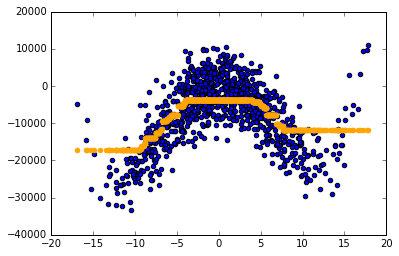

61


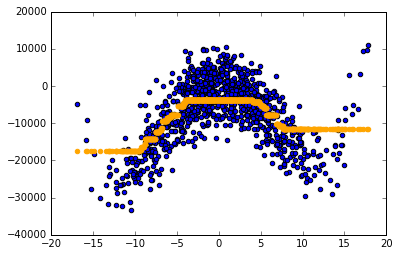

62


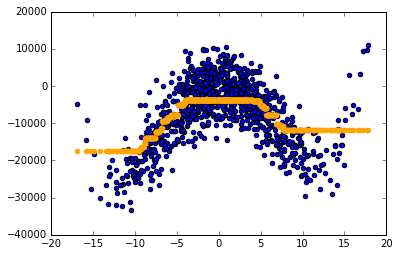

63


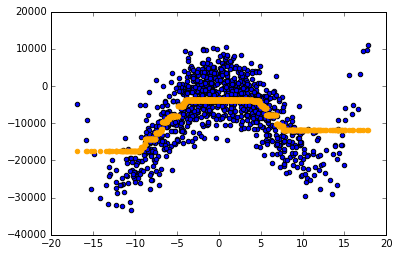

64


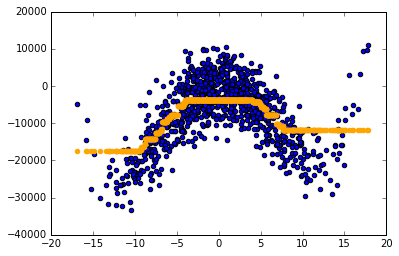

65


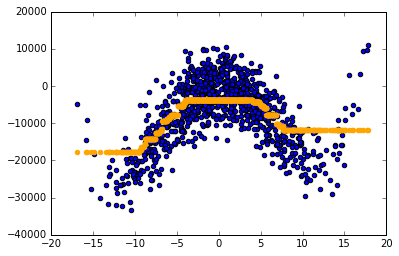

66


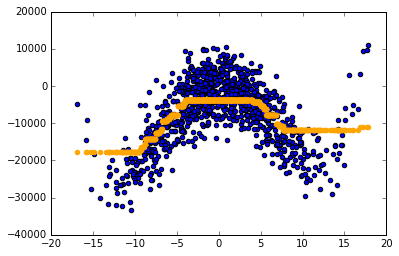

67


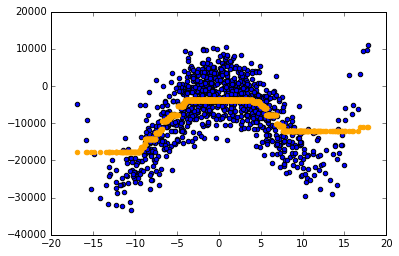

68


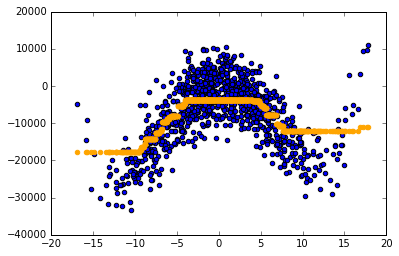

69


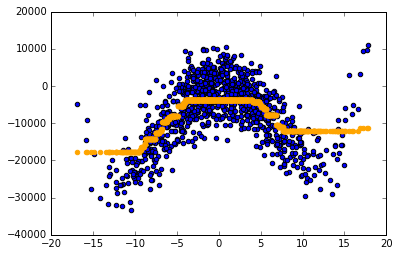

70


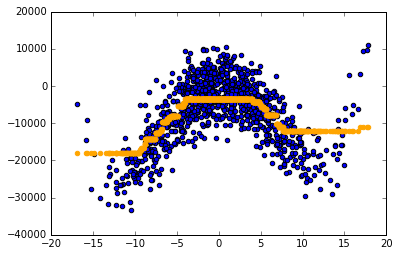

71


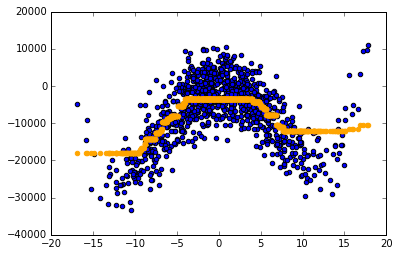

72


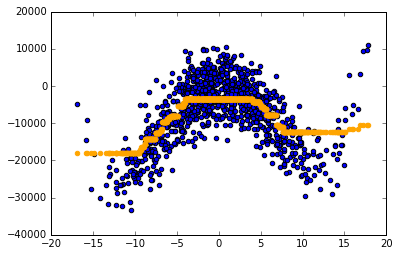

73


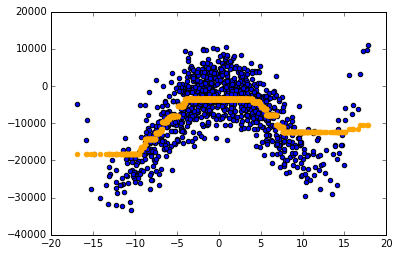

74


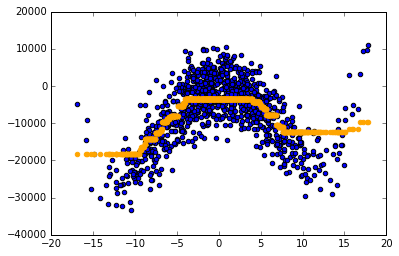

75


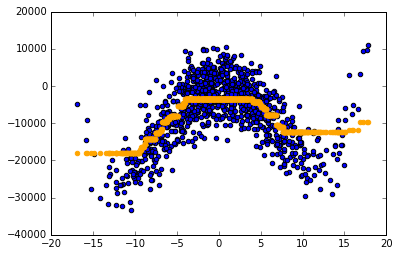

76


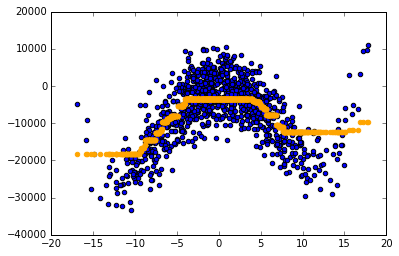

77


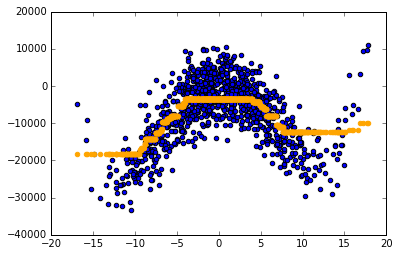

78


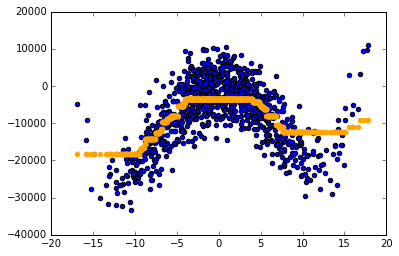

79


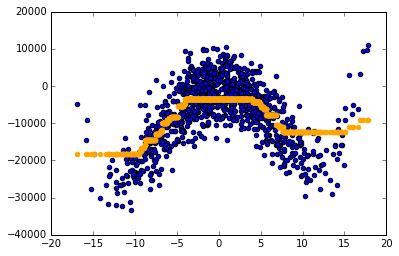

80


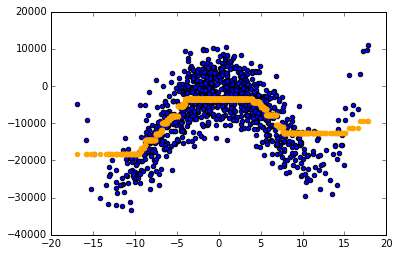

81


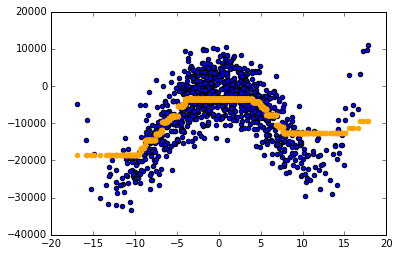

82


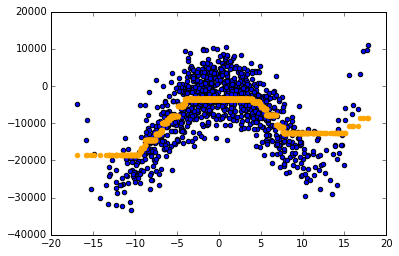

83


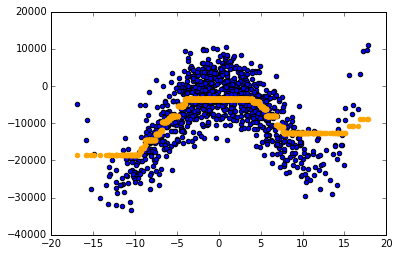

84


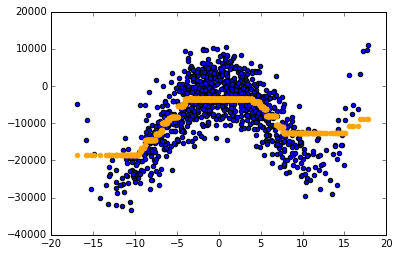

85


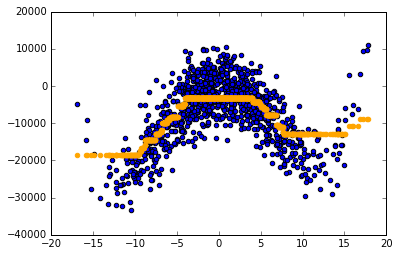

86


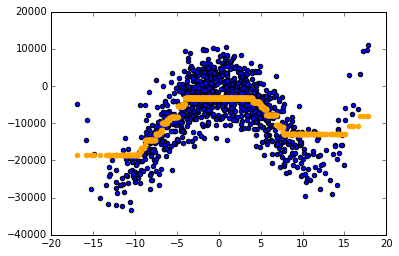

87


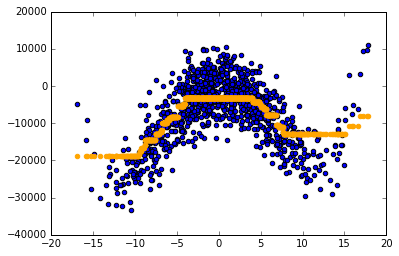

88


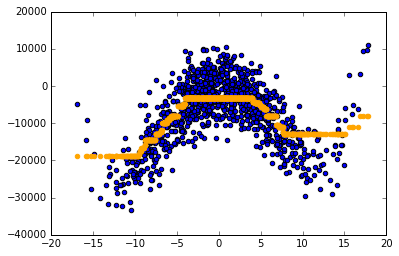

89


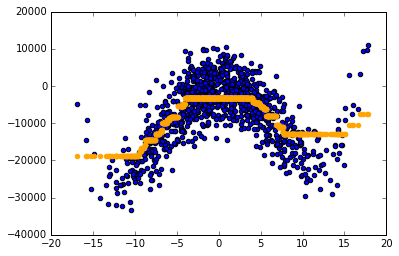

90


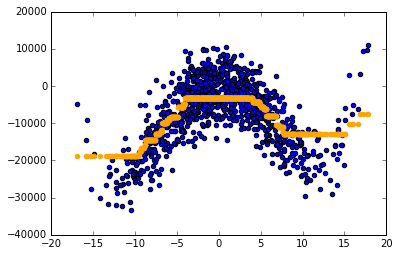

91


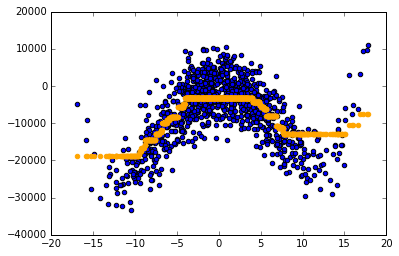

92


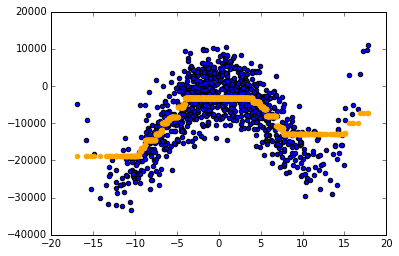

93


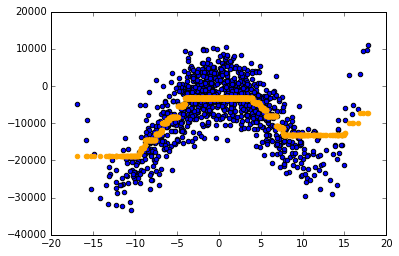

94


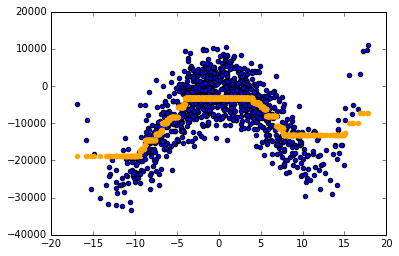

95


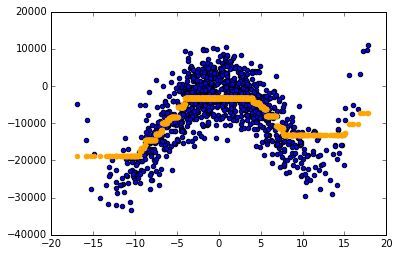

96


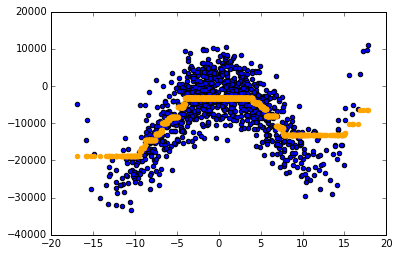

97


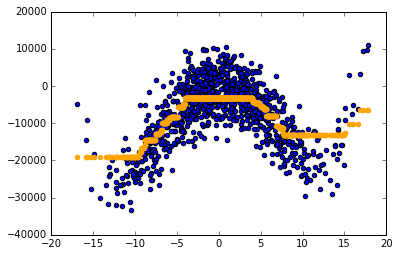

98


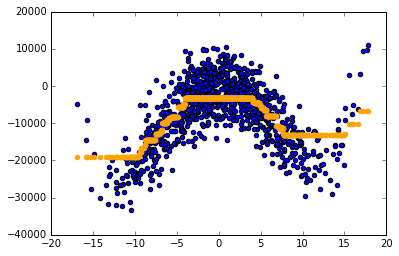

99


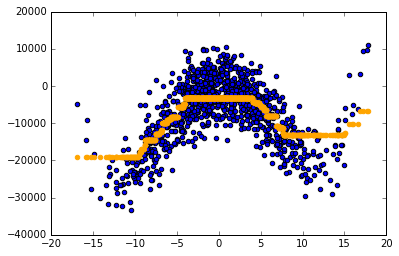

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

df = pd.read_csv('data.csv')
x = df['x']
y = df['y']

plt.scatter(x,y)
plt.show()

mu = y.mean()
dy = y - mu
mu_dots = dy + mu + mu - y

n_boost = 100

model = []
# plt.scatter(x, y)
# plt.scatter(x, mu_dots, color = 'orange')
# plt.show()

# plt.scatter(x, dy, color = 'green')
# plt.show()

alpha = 1

for i in range(n_boost):
    print(i)
    tree = DecisionTreeRegressor(max_depth=1)
    tree.fit(x.values.reshape(-1, 1), dy)
    model = model + [tree]
    predictions = tree.predict(x.values.reshape(-1, 1))
#     plt.scatter(x, dy, color='green')
    dy = dy - alpha * predictions
    
    #first plot the model that I just built
#     plt.scatter(x, predictions, color='orange')
#     plt.show()
    
    
    plt.scatter(x, y)

    predict = mu
    for j in model:
        predict = alpha * j.predict(x.values.reshape(-1, 1)) + predict
                           
    plt.scatter(x, predict, color = 'orange')

    plt.show()
#     plt.scatter(x, dy, color = 'green')
#     plt.show()